In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df=pd.read_csv('MSFT.csv')# this is the microsoft dataset downloaded from yahoo finance

In [ ]:
dff= df[['Close']]  # Select  'Close' columns

In [ ]:
dff.head()

,Close
0,0.097222
1,0.100694
2,0.102431
3,0.099826
4,0.098090


In [ ]:
# Define the split time
split_time = -30
x_train = dff['Close'][:split_time]



In [ ]:
from sklearn.preprocessing import MinMaxScaler
x_train = np.array(x_train).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)



In [ ]:
x_train

array([[1.61759331e-05],
       [2.42638997e-05],
       [2.83102125e-05],
       ...,
       [9.26551389e-01],
       [9.47097452e-01],
       [9.63124309e-01]])

In [ ]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
  #  dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [ ]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

NameError: name 'history' is not defined

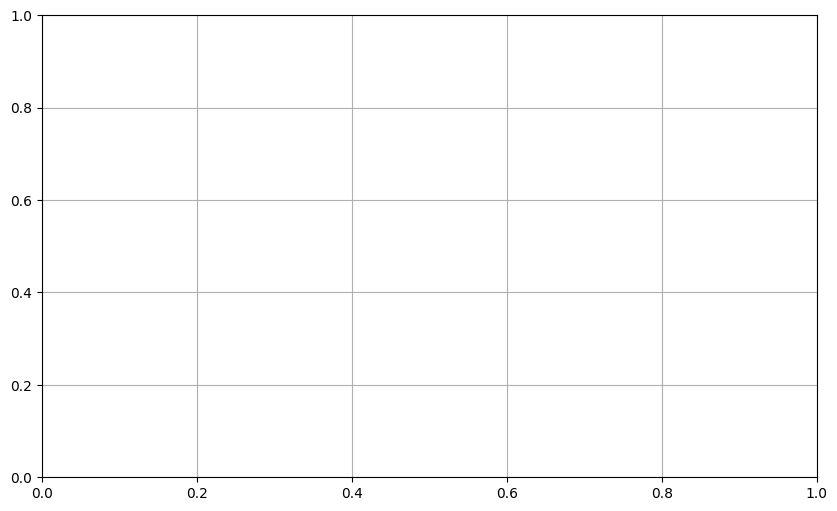

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 5e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
300/300 [==============================] - 38s 88ms/step - loss: 0.1813 - mae: 0.3841
Epoch 2/100
300/300 [==============================] - 26s 88ms/step - loss: 0.5400 - mae: 0.9158
Epoch 3/100
300/300 [==============================] - 26s 87ms/step - loss: 0.5065 - mae: 0.7780
Epoch 4/100
300/300 [==============================] - 26s 86ms/step - loss: 0.4023 - mae: 0.6281
Epoch 5/100
300/300 [==============================] - 26s 88ms/step - loss: 0.1670 - mae: 0.3492
Epoch 6/100
300/300 [==============================] - 31s 103ms/step - loss: 0.0899 - mae: 0.2573
Epoch 7/100
300/300 [==============================] - 26s 88ms/step - loss: 0.1015 - mae: 0.2523
Epoch 8/100
300/300 [==============================] - 26s 87ms/step - loss: 0.0967 - mae: 0.2691
Epoch 9/100
300/300 [==============================] - 26s 88ms/step - loss: 0.2158 - mae: 0.3981
Epoch 10/100
300/300 [==============================] - 27s 90ms/step - loss: 0.1180 - mae: 0.2642
Epoch 11/100
300/3

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [ ]:
def iterative_forecast(model, series, window_size, batch_size, num_predictions):
    predictions = []
    input_series = series
    for _ in range(num_predictions):
        forecast = model_forecast(model, input_series, window_size, batch_size)
        next_prediction = forecast[-1]
        predictions.append(next_prediction)
        # Update the input series by appending the latest prediction
        input_series = np.append(input_series, next_prediction)
        input_series = input_series[-(window_size + 1):]
    return np.array(predictions)

In [ ]:
# Get the validation data (last month)
x_valid = dff['Close'][split_time:-1]

# Prepare the series for forecasting
x_train_1 = dff['Close'][split_time-window_size:-30]
x_train_1 = np.array(x_train_1).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_1 = scaler.fit_transform(x_train_1)
x_train_1 = x_train_1.reshape(-1)
forecast_series = x_train_1

In [ ]:

num_predictions = 30
predictions = iterative_forecast(model, forecast_series, window_size, batch_size, num_predictions)

# Denormalize the predictions
predictions = predictions.reshape(-1, 1)
denormalized_predictions = scaler.inverse_transform(predictions)


# Print or return results
print("Predictions:", denormalized_predictions)
print("Actual values:", x_valid)

1/1 [==============================] - 0s 68ms/step
Predictions: [[417.26898]
 [420.13895]
 [422.8055 ]
 [425.22794]
 [426.90683]
 [429.47482]
 [431.79086]
 [433.86743]
 [434.1779 ]
 [435.19324]
 [435.59192]
 [436.0559 ]
 [435.319  ]
 [436.11438]
 [437.172  ]
 [436.9497 ]
 [437.58478]
 [439.44473]
 [441.10083]
 [441.28433]
 [440.31238]
 [440.11655]
 [441.26773]
 [440.1138 ]
 [441.34003]
 [444.4436 ]
 [445.19022]
 [446.03857]
 [445.7232 ]
 [445.40518]]
Actual values: 9614    409.339996
9615    410.540009
9616    412.320007
9617    414.739990
9618    413.720001
9619    416.559998
9620    423.079987
9621    420.989990
9622    420.209991
9623    425.339996
9624    429.040009
9625    430.519989
9626    427.000000
9627    430.160004
9628    430.320007
9629    429.170013
9630    414.670013
9631    415.130005
9632    413.519989
9633    416.070007
9634    424.010010
9635    424.519989
9636    423.850006
9637    427.869995
9638    432.679993
9639    441.059998
9640    441.579987
9641    442.5700

In [ ]:
results=denormalized_predictions
results_df = pd.DataFrame(results, columns=['Predictions'])
print(results_df)
print('test')
x_valid.reset_index(drop=True,inplace=True)
print(x_valid)

    Predictions
0    417.268982
1    420.138947
2    422.805511
3    425.227936
4    426.906830
5    429.474823
6    431.790863
7    433.867432
8    434.177887
9    435.193237
10   435.591919
11   436.055908
12   435.319000
13   436.114380
14   437.171997
15   436.949707
16   437.584778
17   439.444733
18   441.100830
19   441.284332
20   440.312378
21   440.116547
22   441.267731
23   440.113800
24   441.340027
25   444.443604
26   445.190216
27   446.038574
28   445.723206
29   445.405182
test
0     409.339996
1     410.540009
2     412.320007
3     414.739990
4     413.720001
5     416.559998
6     423.079987
7     420.989990
8     420.209991
9     425.339996
10    429.040009
11    430.519989
12    427.000000
13    430.160004
14    430.320007
15    429.170013
16    414.670013
17    415.130005
18    413.519989
19    416.070007
20    424.010010
21    424.519989
22    423.850006
23    427.869995
24    432.679993
25    441.059998
26    441.579987
27    442.570007
28    448.369995
Name: 

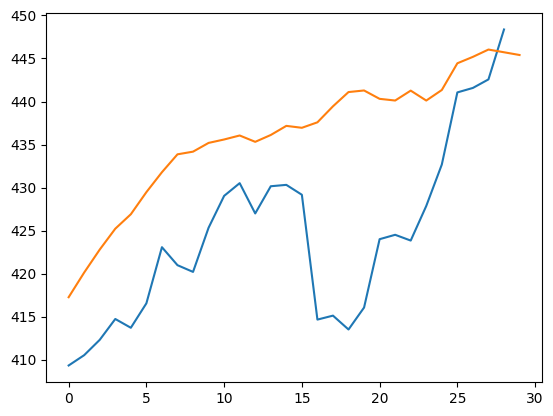

In [ ]:

#results.reset_index()

plt.plot((x_valid))
plt.plot(results_df)
plt.show()

In [ ]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results_df).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results_df).numpy())


[153.20702 120.24498 104.38252 102.30007 107.74249 126.97303 155.62843
 190.4425  196.3884  217.18077 225.90874 236.46669 219.89967 237.82774
 263.6265  258.01843 274.30252 326.63498 379.0545  385.2004  353.414
 347.23828 384.6416  347.15222 387.07904 501.57166 531.98914 567.90497
 554.38556 540.95374]
[ 9.665832  8.775153  8.251808  8.210132  8.491868  9.266989 10.606771
 12.049174 12.273987 13.00924  13.297941 13.633933 13.10031  13.676275
 14.442136 14.281167 14.741046 16.08791  17.289968 17.435505 16.716204
 16.574396 17.422338 16.572407 17.479677 20.26784  20.96296  21.752811
 21.45919  21.163101]


In [2]:
import numpy as np
predictions = [417.268982, 420.138947, 422.805511, 425.227936, 426.906830, 429.474823, 431.790863, 433.867432, 434.177887, 435.193237, 435.591919, 436.055908, 435.319000, 436.114380, 437.171997, 436.949707, 437.584778, 439.444733, 441.100830, 441.284332, 440.312378, 440.116547, 441.267731, 440.113800, 441.340027, 444.443604, 445.190216, 446.038574, 445.723206]
test = [409.339996, 410.540009, 412.320007, 414.739990, 413.720001, 416.559998, 423.079987, 420.989990, 420.209991, 425.339996, 429.040009, 430.519989, 427.000000, 430.160004, 430.320007, 429.170013, 414.670013, 415.130005, 413.519989, 416.070007, 424.010010, 424.519989, 423.850006, 427.869995, 432.679993, 441.059998, 441.579987, 442.570007, 448.369995]

new_predictions_array = np.array(predictions)
test_array = np.array(test)

# Calculate absolute mean error
absolute_errors = np.abs(new_predictions_array - test_array)
absolute_mean_error = np.mean(absolute_errors)
print(absolute_mean_error)

11.529645241379315
